#Group 42 - COMP34812


**Task A :** Natural Language Inference (NLI)

Given a premise and a hypothesis, determine if the hypothesis is true based on the premise. You will be given more than 26K premise-hypothesis pairs as training data, and more than 6K pairs as validation data.

**Solution B :** Deep learning-based approaches that do not employ transformer architectures

*Our final model used an ensemble approach where predictions from 4 models LSTM, GRU, BiLSTM and BiGRU are combined using soft voting. Pre-trained GloVe embeddings were used. These models were trained on the dataset.*

**Group 42 :** Aisha Wahid & Libby Walton

Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tempfile
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import RMSprop
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, TimeDistributed
from tensorflow.keras.layers import BatchNormalization, Bidirectional, LSTM, concatenate, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, accuracy_score
import matplotlib.pyplot as plt

## Prepare

### Load Dataset

In [2]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
dev_df = pd.read_csv('/content/drive/MyDrive/dev.csv')
dev_df['hypothesis'] = dev_df['hypothesis'].astype(str)

In [18]:
train_df['corpus'] = train_df['premise'] + ' [SEP] ' + train_df['hypothesis']
dev_df['corpus'] = dev_df['premise'] + ' [SEP] ' + dev_df['hypothesis']

### Preprocessing - reduces the performance so not included

In [ ]:
'''nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def preprocess(column):
  column = column.str.lower()
  column = column.str.replace(r'[^\w\s]', '', regex=True)
  column = column.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
  column =  column = column.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
  return column'''

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
train_df['hypothesis'] = preprocess(train_df['hypothesis'])
train_df['premise'] = preprocess(train_df['premise'])

,premise,hypothesis,label
0,"However, Fort Charles was rebuilt as a militar...",fort charles wa rebuilt a an amusement park fo...,0
1,Buchanan's The Democrats and Republicans have...,the party will never be similar,0
2,In order to review an acquisition that is usin...,the auditor only review the acquisition itself...,0
3,Three young people sit outside and engage with...,there is a tin can and string telephone,0
4,The lucrative tin mines of Kuala Lumpur in the...,the chinese labor wa seen a le costly and more...,1
...,...,...,...
26939,Information in agencies' plans and reports pro...,thanks to agency plan and report over 30 billi...,0
26940,"He is the Mr. Magoo of scientific theory, geni...",he understands everything he cant see,0
26941,"Over the past 25 years, the Postal Service has...",classifying mail is important to the function ...,1
26942,Whoever first stepped ashore on Madeira discov...,the british discovered the canary island first,0


## Model Training

### Embeddings

This code can be ran or the Glove tokenizer can be loaded from the link in the Google Drive

In [5]:
# Load in the tokenizer generated in training from Glove embeddings
import pickle
with open('/content/drive/MyDrive/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [7]:
# Download the GloVe pre-trained word embeddings file (840B tokens, 300-dimensional vectors)
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip
# Unzip the downloaded file
!unzip glove.840B.300d.zip
!ls -lat

--2024-04-22 11:42:01--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2024-04-22 11:42:01--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2024-04-22 11:42:01--  https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/

In [36]:
embedding_dict = {}
# Open the GloVe embedding file
glove_dir = 'glove.840B.300d.txt'
file = open(glove_dir, encoding="utf8")

for line in file:
    # Spilt the word and its embedding vector
    line_list = line.split(' ')
    word = line_list[0]
    embeddings = np.asarray(line_list[1:], dtype='float32')

    # Store the word and its embedding vector in a dictionary
    embedding_dict[word] = embeddings

file.close()

In [44]:
# Initialize and fit Keras tokenizer to convert words to integers
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(train_df['corpus'])

# Get an word-integer dictionary and use that to create an weight matrix
# i-th column of weight matrix will have the vector of word with integer value i in dictionary
word_index = tokenizer.word_index
embed_matrix = np.zeros((len(word_index) + 1, 300))

for word, ind in word_index.items():
    # Get the embedding vector from GloVe dictionary, if available
    # Words not in the Glove would have the embedding matrix vector as random values uniformly generated between -0.05 and 0.05
    embedding_vector = embedding_dict.get(word)

    if embedding_vector is not None:
        embed_matrix[ind] = embedding_vector
    else:
        embed_matrix[ind] = np.array([np.random.uniform(-0.05, 0.05) for _ in range(300)])

In [6]:
# Pad and tokenize the training dataset
labels = np.array(train_df['label'])
premise = np.array(train_df['premise'])
hypothesis = np.array(train_df['hypothesis'])
data_converted = [premise, hypothesis, labels]

In [7]:
# Process the data to integer sequences and labels to one-hot labels
sequence = lambda sentence: pad_sequences(tokenizer.texts_to_sequences(sentence), maxlen=84)
process = lambda item: (sequence(item[0]), sequence(item[1]), to_categorical(item[2]))

training_data = process(data_converted)

In [8]:
# Pad and tokenize the development dataset
dev_labels = to_categorical(np.array(dev_df['label']))
dev_premise = pad_sequences(tokenizer.texts_to_sequences(np.array(dev_df['premise'])), maxlen=84)
dev_df['hypothesis'] = dev_df['hypothesis'].astype(str)
dev_hypothesis = pad_sequences(tokenizer.texts_to_sequences(np.array(dev_df['hypothesis'])), maxlen=84)

### Training

Training Function

In [24]:
def train_model(approach, bidirectional):
  max_len = 84
  embedding = Embedding(input_dim=embed_matrix.shape[0],
                            output_dim=300,
                            weights=[embed_matrix],
                            input_length=84,
                            trainable=False)

  # Determine whether to use bidirectional layer or not
  if (bidirectional == True):
    layer = Bidirectional(approach)
  else:
    layer = approach

  premise = Input(shape=(max_len,), dtype='int32')
  hypothesis = Input(shape=(max_len,), dtype='int32')

  premise_embedded = embedding(premise)
  hypothesis_embedded = embedding(hypothesis)

  premise_layer = layer(premise_embedded)
  hypothesis_layer = layer(hypothesis_embedded)

  premise_normalized = BatchNormalization()(premise_layer)
  hypothesis_normalized = BatchNormalization()(hypothesis_layer)

  train_input = concatenate([premise_normalized, hypothesis_normalized])
  train_input = Dropout(0.2)(train_input)

  train_input = Dense(100, activation='relu', kernel_regularizer=l2(1e-6))(train_input)
  train_input = Dropout(0.2)(train_input)
  train_input = BatchNormalization()(train_input)

  prediction = Dense(2, activation='softmax')(train_input)

  model = Model(inputs=[premise, hypothesis], outputs=prediction)

  optimizer = RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()

  learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                              patience=4,
                                              verbose=1,
                                              factor=0.5,
                                              min_lr=0.00001)

  early_stopping = EarlyStopping(monitor='val_loss',
                                  patience=4)

  _, tmpfn = tempfile.mkstemp()
  model_checkpoint = ModelCheckpoint(tmpfn, save_best_only=True, save_weights_only=True)

  callbacks = [early_stopping, model_checkpoint, learning_rate_reduction]

  # Train the model
  history = model.fit(x=[training_data[0], training_data[1]],
                          y=training_data[2],
                      batch_size=32,
                      epochs=50,
                      validation_data=([dev_premise, dev_hypothesis], dev_labels),
                      callbacks=callbacks)
  return model

Training LSTM

In [25]:
#Training the LSTM model
lstm_model = train_model(LSTM(64), False)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 84)]                 0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 84)]                 0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 84, 300)              1101150   ['input_11[0][0]',            
                                                          0          'input_12[0][0]']            
                                                                                                  
 lstm_5 (LSTM)               (None, 64)                   93440     ['embedding_5[0][0]',   

Training GRU

In [ ]:
#Training the GRU model
gru_model = train_model(GRU(64), False)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 84)]                 0         []                            
                                                                                                  
 input_22 (InputLayer)       [(None, 84)]                 0         []                            
                                                                                                  
 embedding_10 (Embedding)    (None, 84, 300)              1101120   ['input_21[0][0]',            
                                                          0          'input_22[0][0]']            
                                                                                                  
 gru_2 (GRU)                 (None, 64)                   70272     ['embedding_10[0][0]',  

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/rmsprop.py:144: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
842/842 [==============================] - 21s 21ms/step - loss: 0.6585 - accuracy: 0.6231 - val_loss: 0.6167 - val_accuracy: 0.6570 - lr: 0.0100
Epoch 2/50
842/842 [==============================] - 19s 22ms/step - loss: 0.6107 - accuracy: 0.6622 - val_loss: 0.6040 - val_accuracy: 0.6657 - lr: 0.0100
Epoch 3/50
842/842 [==============================] - 23s 27ms/step - loss: 0.5985 - accuracy: 0.6766 - val_loss: 0.5953 - val_accuracy: 0.6654 - lr: 0.0100
Epoch 4/50
842/842 [==============================] - 24s 29ms/step - loss: 0.5875 - accuracy: 0.6843 - val_loss: 0.5865 - val_accuracy: 0.6813 - lr: 0.0100
Epoch 5/50
842/842 [==============================] - 21s 24ms/step - loss: 0.5800 - accuracy: 0.6913 - val_loss: 0.5907 - val_accuracy: 0.6666 - lr: 0.0100
Epoch 6/50
842/842 [==============================] - 21s 26ms/step - loss: 0.5770 - accuracy: 0.6973 - val_loss: 0.6018 - val_accuracy: 0.6840 - lr: 0.0100
Epoch 7/50
842/842 [==============================] - 27s 

Training BiLSTM

In [ ]:
#Training the BiLSTM model
bilstm_model = train_model(LSTM(64), True)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_23 (InputLayer)       [(None, 84)]                 0         []                            
                                                                                                  
 input_24 (InputLayer)       [(None, 84)]                 0         []                            
                                                                                                  
 embedding_11 (Embedding)    (None, 84, 300)              1101120   ['input_23[0][0]',            
                                                          0          'input_24[0][0]']            
                                                                                                  
 bidirectional_4 (Bidirecti  (None, 128)                  186880    ['embedding_11[0][0]', 

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/rmsprop.py:144: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
842/842 [==============================] - 43s 40ms/step - loss: 0.6651 - accuracy: 0.6129 - val_loss: 0.6549 - val_accuracy: 0.6409 - lr: 0.0100
Epoch 2/50
842/842 [==============================] - 23s 27ms/step - loss: 0.6134 - accuracy: 0.6611 - val_loss: 0.6169 - val_accuracy: 0.6541 - lr: 0.0100
Epoch 3/50
842/842 [==============================] - 23s 28ms/step - loss: 0.5980 - accuracy: 0.6777 - val_loss: 0.6086 - val_accuracy: 0.6729 - lr: 0.0100
Epoch 4/50
842/842 [==============================] - 23s 27ms/step - loss: 0.5873 - accuracy: 0.6872 - val_loss: 0.6062 - val_accuracy: 0.6650 - lr: 0.0100
Epoch 5/50
842/842 [==============================] - 23s 28ms/step - loss: 0.5747 - accuracy: 0.6996 - val_loss: 0.6332 - val_accuracy: 0.6614 - lr: 0.0100
Epoch 6/50
842/842 [==============================] - 23s 27ms/step - loss: 0.5610 - accuracy: 0.7074 - val_loss: 0.6100 - val_accuracy: 0.6589 - lr: 0.0100
Epoch 7/50
842/842 [==============================] - 25s 

Training BiGRU

In [ ]:
#Training the BiGRU model
bigru_model = train_model(GRU(64), True)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 84)]                 0         []                            
                                                                                                  
 input_26 (InputLayer)       [(None, 84)]                 0         []                            
                                                                                                  
 embedding_12 (Embedding)    (None, 84, 300)              1101120   ['input_25[0][0]',            
                                                          0          'input_26[0][0]']            
                                                                                                  
 bidirectional_5 (Bidirecti  (None, 128)                  140544    ['embedding_12[0][0]', 

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/rmsprop.py:144: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
842/842 [==============================] - 33s 30ms/step - loss: 0.6554 - accuracy: 0.6276 - val_loss: 0.6668 - val_accuracy: 0.6215 - lr: 0.0100
Epoch 2/50
842/842 [==============================] - 22s 27ms/step - loss: 0.6084 - accuracy: 0.6653 - val_loss: 0.6054 - val_accuracy: 0.6739 - lr: 0.0100
Epoch 3/50
842/842 [==============================] - 21s 25ms/step - loss: 0.5910 - accuracy: 0.6813 - val_loss: 0.6059 - val_accuracy: 0.6644 - lr: 0.0100
Epoch 4/50
842/842 [==============================] - 21s 24ms/step - loss: 0.5879 - accuracy: 0.6877 - val_loss: 0.5945 - val_accuracy: 0.6754 - lr: 0.0100
Epoch 5/50
842/842 [==============================] - 20s 24ms/step - loss: 0.5848 - accuracy: 0.6866 - val_loss: 0.5982 - val_accuracy: 0.6763 - lr: 0.0100
Epoch 6/50
842/842 [==============================] - 19s 23ms/step - loss: 0.5742 - accuracy: 0.6979 - val_loss: 0.5965 - val_accuracy: 0.6867 - lr: 0.0100
Epoch 7/50
842/842 [==============================] - 19s 

## Ensemble

### Load Models

After hyperparameter tuning and evaluation, the best performing models were saved on the Google Drive. If you want to run the ensemble with these models please download the models as linked in the readme from the Google Drive and adjust paths as needed. Alternatively you can train each model using the code above in **Model Training**.


In [9]:
import pickle
# Load the models - paths need to point to where the models are saved in your Google Drive
with open('/content/drive/MyDrive/DNN Model/model_bilstm_70','rb') as f:
    bilstm_model = pickle.load(f)
with open('/content/drive/MyDrive/DNN Model/model_bigru_68','rb') as f:
    bigru_model = pickle.load(f)
with open('/content/drive/MyDrive/DNN Model/model_lstm_68','rb') as f:
    lstm_model = pickle.load(f)
with open('/content/drive/MyDrive/DNN Model/model_gru_65','rb') as f:
    gru_model = pickle.load(f)

### Ensemble

Hard voting

In [10]:
ensemble_predictions = (bilstm_model.predict([dev_premise, dev_hypothesis]) + bigru_model.predict([dev_premise, dev_hypothesis]) + lstm_model.predict([dev_premise, dev_hypothesis]) + gru_model.predict([dev_premise, dev_hypothesis]))
predicted_labels_hard = ensemble_predictions.argmax(axis=1)

211/211 [==============================] - 10s 45ms/step


Soft Voting

In [11]:
accuracies = [0.7006085794864183, 0.6805699866409382, 0.6827964969571025,  0.654890900994508]

# Normalize accuracies to sum up to 1
weights = [accuracy / sum(accuracies) for accuracy in accuracies]

# Aggregate predictions using weighted soft voting
ensemble_predictions = (bilstm_model.predict([dev_premise, dev_hypothesis]) * weights[0] + bigru_model.predict([dev_premise, dev_hypothesis]) * weights[1] +
                  lstm_model.predict([dev_premise, dev_hypothesis]) * weights[2] + gru_model.predict([dev_premise, dev_hypothesis]) * weights[3])
predicted_labels_soft = ensemble_predictions.argmax(axis=1)

211/211 [==============================] - 9s 45ms/step


### Writing to dataframe

In [ ]:
result_df = pd.DataFrame({'prediction': predicted_labels_soft})
column_name_row = pd.DataFrame({'prediction': ['prediction']}, index=[0])
result_df['prediction'] = result_df['prediction'].astype(int)
result_df = pd.concat([column_name_row, result_df]).reset_index(drop=True)
result_df

,prediction
0,prediction
1,1
2,0
3,1
4,0
...,...
6733,0
6734,1
6735,1
6736,0


In [ ]:
result_df.to_csv('ensemble-dnn.csv', encoding='utf-8', index=False, header=False)

## Evaluation

In [12]:
# Evaluation function to measure model performance on the same metrics as in EvalAI
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, accuracy_score, confusion_matrix
import seaborn as sns
# Evaluation function to measure model performance on the same metrics as in EvalAI
def evaluate(actual, predicted):
  accuracy = accuracy_score(actual, predicted)
  print(f"Accuracy: {accuracy}")
  report = classification_report(actual,predicted)
  print(f"Classification report: {report}")
  f1_macro = f1_score(actual,predicted,average='macro')
  print(f"F1 score - macro:, {f1_macro}")
  precision_macro = precision_score(actual,predicted,average='macro')
  print(f"Precision - macro: {precision_macro}")
  recall_macro = recall_score(actual,predicted,average='macro')
  print(f"Recall - macro: {recall_macro}")
  f1_weighted = f1_score(actual, predicted, average='weighted')
  print(f"F1 score (weighted): {f1_weighted}")
  precision_weighted = precision_score(actual, predicted, average='weighted')
  print(f"Precision (weighted): {precision_weighted}")
  recall_weighted = recall_score(actual, predicted, average='weighted')
  print(f"Recall (weighted): {recall_weighted}")
  labels =[0,1]
  cm = confusion_matrix(actual, predicted)
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, cmap="Blues", fmt='g', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

### Evaluating LSTM Model

211/211 [==============================] - 11s 54ms/step
Accuracy: 0.6827964969571025
Classification report:               precision    recall  f1-score   support

           0       0.67      0.66      0.67      3259
           1       0.69      0.70      0.69      3478

    accuracy                           0.68      6737
   macro avg       0.68      0.68      0.68      6737
weighted avg       0.68      0.68      0.68      6737

F1 score - macro:, 0.6822937351574836
Precision - macro: 0.6824356300793081
Recall - macro: 0.6822242682315933
F1 score (weighted): 0.6827045740907544
Precision (weighted): 0.682684935587942
Recall (weighted): 0.6827964969571025


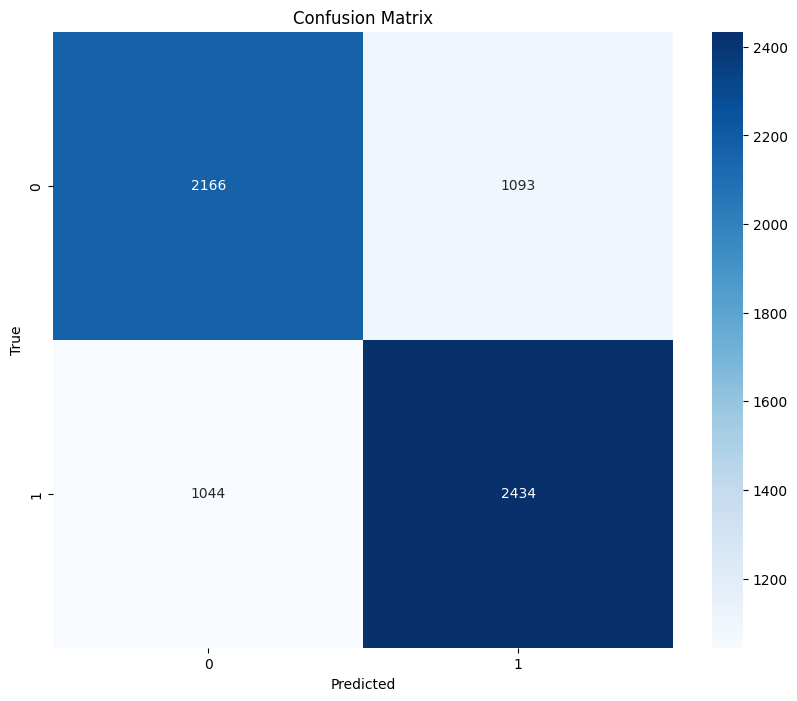

In [13]:
predictions = lstm_model.predict(x=[dev_premise, dev_hypothesis], batch_size=32)
predicted_labels = predictions.argmax(axis=1)
lstm_acc = accuracy_score(np.array(dev_df['label']), predicted_labels)
evaluate(np.array(dev_df['label']), predicted_labels)

### Evaluating GRU Model

211/211 [==============================] - 10s 48ms/step
Accuracy: 0.654890900994508
Classification report:               precision    recall  f1-score   support

           0       0.81      0.37      0.51      3259
           1       0.61      0.92      0.73      3478

    accuracy                           0.65      6737
   macro avg       0.71      0.65      0.62      6737
weighted avg       0.71      0.65      0.63      6737

F1 score - macro:, 0.6219738011501139
Precision - macro: 0.7116475633887309
Recall - macro: 0.6459811119770773
F1 score (weighted): 0.6255999806601351
Precision (weighted): 0.7083391500098821
Recall (weighted): 0.654890900994508


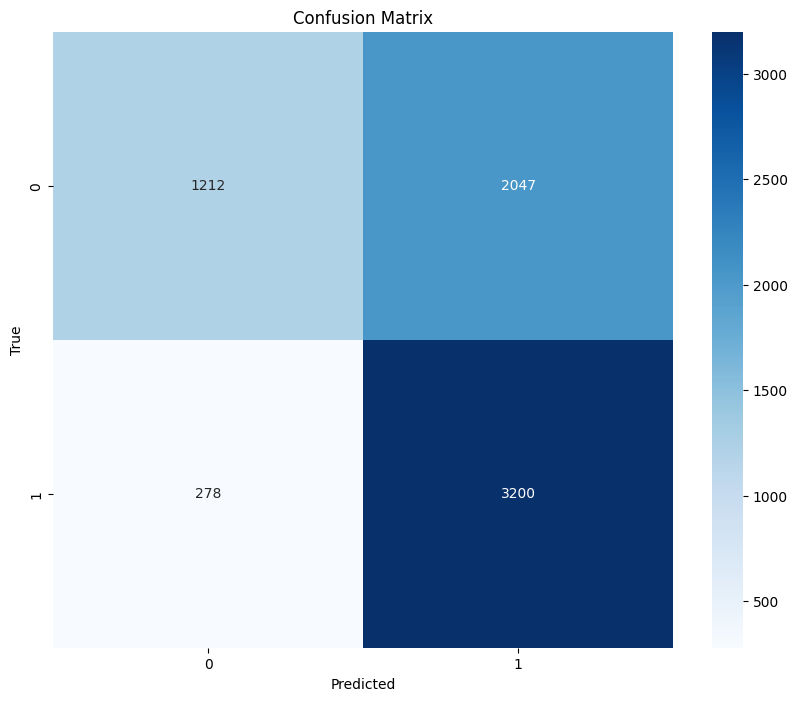

In [14]:
predictions = gru_model.predict(x=[dev_premise, dev_hypothesis], batch_size=32)
predicted_labels = predictions.argmax(axis=1)
gru_acc = accuracy_score(np.array(dev_df['label']), predicted_labels)
evaluate(np.array(dev_df['label']), predicted_labels)

### Evaluating BiLSTM Model

211/211 [==============================] - 27s 129ms/step
Accuracy: 0.7006085794864183
Classification report:               precision    recall  f1-score   support

           0       0.69      0.70      0.69      3259
           1       0.71      0.70      0.71      3478

    accuracy                           0.70      6737
   macro avg       0.70      0.70      0.70      6737
weighted avg       0.70      0.70      0.70      6737

F1 score - macro:, 0.7004600871219848
Precision - macro: 0.700442135989011
Recall - macro: 0.7006251631038636
F1 score (weighted): 0.7006768859740579
Precision (weighted): 0.7008921498894085
Recall (weighted): 0.7006085794864183


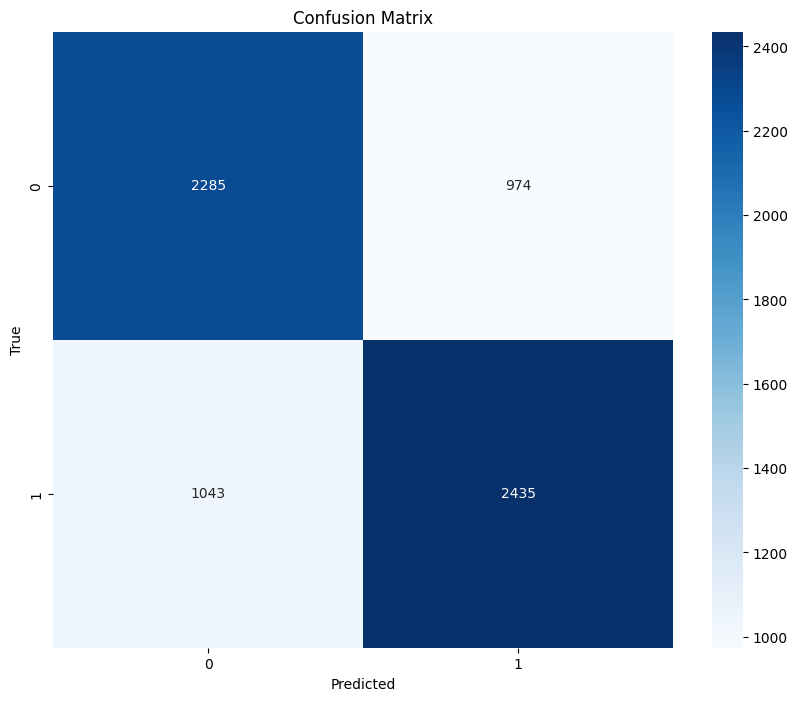

In [15]:
predictions = bilstm_model.predict(x=[dev_premise, dev_hypothesis], batch_size=32)
predicted_labels = predictions.argmax(axis=1)
bilstm_acc = accuracy_score(np.array(dev_df['label']), predicted_labels)
evaluate(np.array(dev_df['label']), predicted_labels)

### Evaluating BiGRU Model

211/211 [==============================] - 18s 86ms/step
Accuracy: 0.6805699866409382
Classification report:               precision    recall  f1-score   support

           0       0.73      0.53      0.62      3259
           1       0.65      0.82      0.73      3478

    accuracy                           0.68      6737
   macro avg       0.69      0.68      0.67      6737
weighted avg       0.69      0.68      0.67      6737

F1 score - macro:, 0.671837225014174
Precision - macro: 0.6923973941330377
Recall - macro: 0.675981459579091
F1 score (weighted): 0.6735774204611815
Precision (weighted): 0.6910885501508397
Recall (weighted): 0.6805699866409382


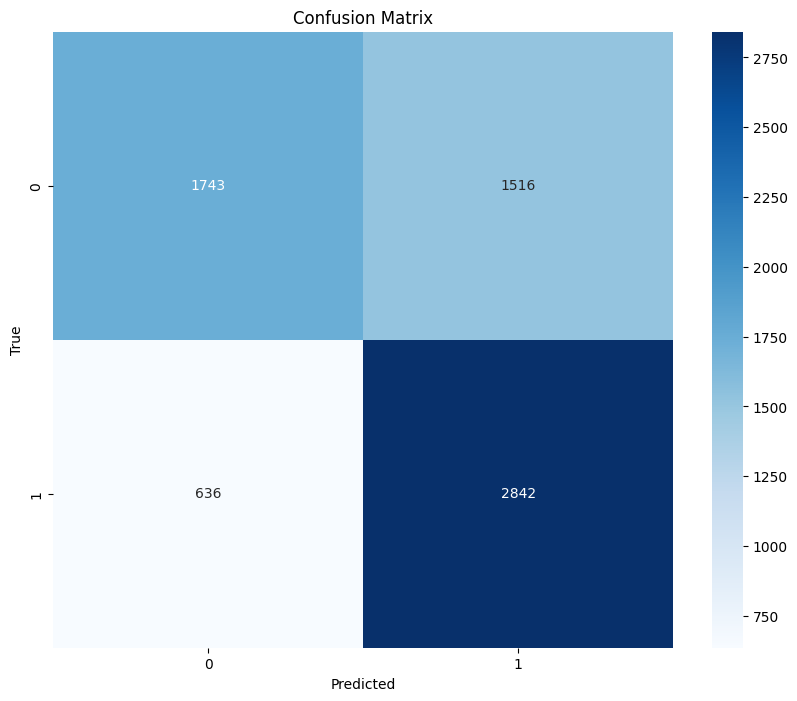

In [16]:
predictions = bigru_model.predict(x=[dev_premise, dev_hypothesis], batch_size=32)
predicted_labels = predictions.argmax(axis=1)
bigru_acc = accuracy_score(np.array(dev_df['label']), predicted_labels)
evaluate(np.array(dev_df['label']), predicted_labels)

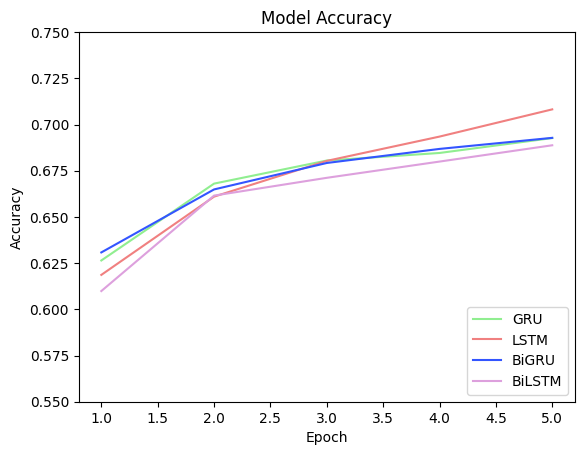

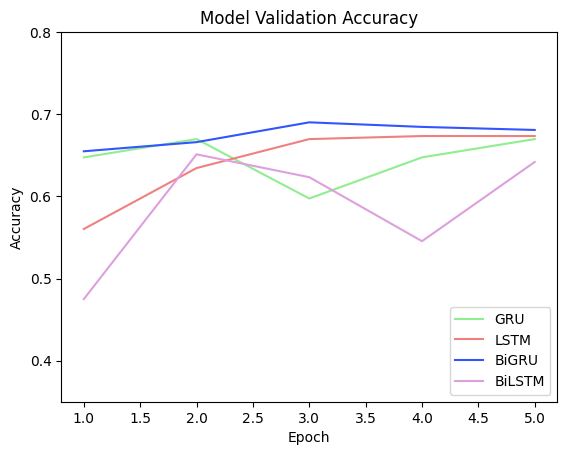

In [ ]:
epochs = range(1, 6)

plt.plot(epochs, history_gru['accuracy'][:5], color="#90EE90")
plt.plot(epochs, history_lstm['accuracy'][:5], color="#F08080")
plt.plot(epochs, history_bigru['accuracy'][:5], color="#3355FF")
plt.plot(epochs, history_bilstm['accuracy'][:5], color="#DDA0DD")

plt.ylim(0.55, 0.75)

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['GRU', 'LSTM', 'BiGRU', 'BiLSTM'], loc='lower right')
plt.show()

import matplotlib.pyplot as plt

epochs = range(1, 6)

plt.plot(epochs, history_gru['val_accuracy'][:5], color="#90EE90")
plt.plot(epochs, history_lstm['val_accuracy'][:5], color="#F08080")
plt.plot(epochs, history_bigru['val_accuracy'][:5], color="#3355FF")
plt.plot(epochs, history_bilstm['val_accuracy'][:5], color="#DDA0DD")

# Set y-axis limits between 0 and 1
plt.ylim(0.35, 0.8)

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['GRU', 'LSTM', 'BiGRU', 'BiLSTM'], loc='lower right')
plt.show()

### Evaluating Ensemble Model

Accuracy: 0.7050616001187472
Classification report:               precision    recall  f1-score   support

           0       0.75      0.58      0.66      3259
           1       0.68      0.82      0.74      3478

    accuracy                           0.71      6737
   macro avg       0.71      0.70      0.70      6737
weighted avg       0.71      0.71      0.70      6737

F1 score - macro:, 0.6992057198828255
Precision - macro: 0.71406664425899
Recall - macro: 0.7012669916951351
F1 score (weighted): 0.7005700153845987
Precision (weighted): 0.7128793446402583
Recall (weighted): 0.7050616001187472


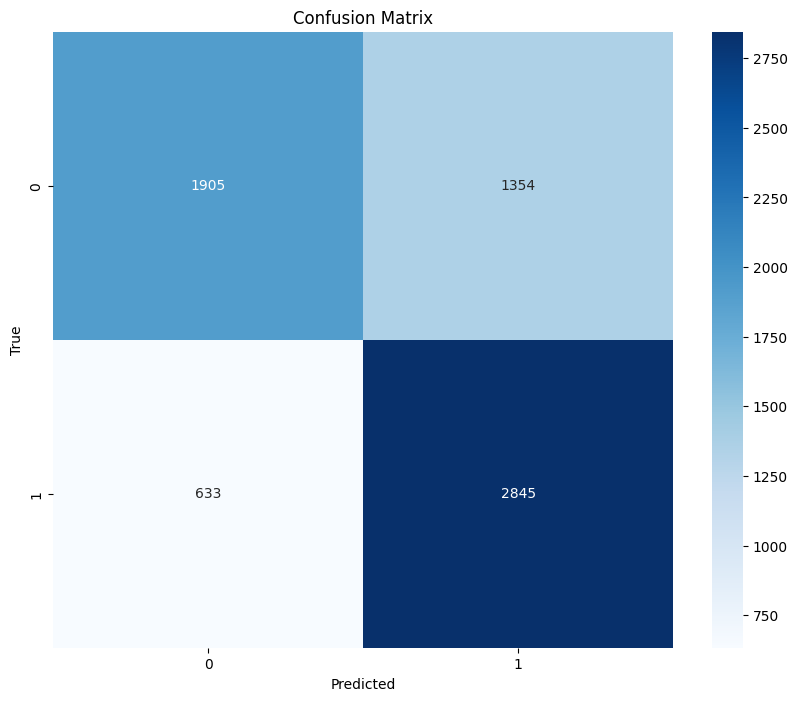

In [17]:
#Hard Voting
evaluate(np.array(dev_df['label']), predicted_labels_hard)

Accuracy: 0.7066943743506011
Classification report:               precision    recall  f1-score   support

           0       0.75      0.59      0.66      3259
           1       0.68      0.82      0.74      3478

    accuracy                           0.71      6737
   macro avg       0.72      0.70      0.70      6737
weighted avg       0.71      0.71      0.70      6737

F1 score - macro:, 0.7011822955377901
Precision - macro: 0.7151079803798144
Recall - macro: 0.7030222495284876
F1 score (weighted): 0.7025015799749547
Precision (weighted): 0.7139642313292882
Recall (weighted): 0.7066943743506011


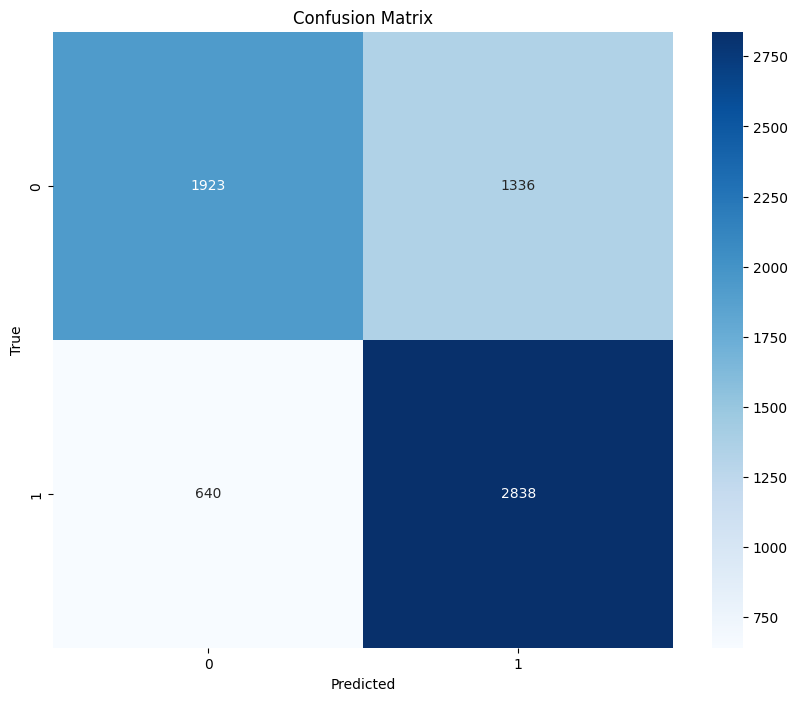

In [18]:
#Soft Voting
evaluate(np.array(dev_df['label']), predicted_labels_soft)